# Setup

## Imports

In [1]:
import pandas as pd
import py2neo
import urllib.request as urllib
from py2neo import Graph,Node,Relationship
import datetime, pytz
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import community
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.vq import whiten
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, mean_absolute_error, mean_squared_error, precision_score, roc_curve
from sklearn.inspection import permutation_importance
import xgboost as xgb

C:\Users\Eva\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load data

In [2]:
### esc =  eurovision song contest
#https://www.kaggle.com/datasets/datagraver/eurovision-song-contest-scores-19752019?resource=download
esc_1975_2019 =  "eurovision_song_contest_1975_2019.xlsx"

#created by us
esc_additional = "Eurovision additional.xlsx"

#http://www.cepii.fr/cepii
geo_cepii = "geo_cepii.xls"

#https://github.com/geodatasource/country-borders/blob/master/GEODATASOURCE-COUNTRY-BORDERS.CSV
geo_borders = "GEODATASOURCE-COUNTRY-BORDERS.csv"

#https://datahub.io/core/country-list#resource-data
iso2 = "iso2.csv"

#https://timezonedb.com/download
time_zone = "time_zone.csv"

#load data in pandas df
df_iso2_convert = pd.read_csv("data/" + iso2)
df_borders = pd.read_csv("data/" + geo_borders)
df_geo = pd.read_excel("data/" + geo_cepii,header=0)
df_additional = pd.read_excel("data/" + esc_additional, header=0)
df_esc = pd.read_excel("data/" + esc_1975_2019,sheet_name = "Data",header=0)

headers = ["zone_name","country_code","abbreviation","time_start","gmt_offset","dst"]
df_timezone = pd.read_csv('data/' +  time_zone,names=headers)

df_features = []
faulty_countries = []
df_country_lookup = []

## Functions

In [3]:
# converts country columm to an iso2 column. Provided a lookup table containing the correct spelling of wrongly spelled countries.
# run with empty lookup_table to get wronly spelled countries and update lookup_table aferwards 
def country_to_iso2(df, columns = [] , lookup_table = []): 
    global faulty_countries
    global df_country_lookup
    faulty_countries = []
    for column in columns:
        df[column].apply(get_faulty_countries)
        try: 
            df_country_lookup = pd.DataFrame({'faulty': faulty_countries, 'correct': lookup_table})
        except:
            print("lookup table does not size of faulty_countries table : \n" + "lookup: " + str(lookup_table) + "\n faulty: " + str(faulty_countries) )
            break
        newname = column + '_iso2'
        df[newname] = df[column].apply(get_iso2)
        
# dds a new country name to an array with wrongly spelled countries
def get_faulty_countries(country):
    global faulty_countries
    code = df_iso2_convert.loc[df_iso2_convert['Name'] == country]["Code"].values
    if code.size == 0:
        if country not in faulty_countries:
            faulty_countries.append(country)

# matches a worngly spelled country to the correct format
def fix_country(country):
    global df_country_lookup
    new_country = df_country_lookup.loc[df_country_lookup["faulty"] == country]["correct"].values 
    if new_country.size > 0:
        return new_country[0]
    else: 
        return "Nan"

# finds the iso2 code for a country name
def get_iso2(country):
    code = df_iso2_convert.loc[df_iso2_convert['Name'] == country]["Code"].values
    if code.size > 0:
        return code[0]
    else:
        return df_iso2_convert.loc[df_iso2_convert['Name'] == fix_country(country)]["Code"].values[0]

# copies features from a dataframe (with an iso2 column) into df_features
def copy_features(df,iso2_column, features = []):    
    for feature in features:
        df_features[feature] = ""
        for index, row in df_features.iterrows():
            val = df.loc[df[iso2_column]== index][feature].values
            if val.size > 0:
                df_features.loc[index,feature] = val[0]
            else:
                row[feature] = "Nan"

                
def get_utc_offset(zone):
    return datetime.datetime.now(pytz.timezone(zone)).strftime('%z')


# Data preprocessing

In [4]:
#Rename countries - Macedonia is changed to the last official name
df_esc['From country'] = df_esc['From country'].replace(['Macedonia'],'North Macedonia')
df_esc['To country'] = df_esc['To country'].replace(['Macedonia'],'North Macedonia')

df_esc['From country'] = df_esc['From country'].replace(['F.Y.R. Macedonia'],'North Macedonia')
df_esc['To country'] = df_esc['To country'].replace(['F.Y.R. Macedonia'],'North Macedonia')

df_esc['From country'] = df_esc['From country'].replace(['The Netherands'],'The Netherlands')
df_esc['To country'] = df_esc['To country'].replace(['The Netherands'],'The Netherlands')

In [5]:
# drop uninteresting columns
df_esc = df_esc.drop(["Duplicate"], axis =1)

# Renaming the Points column to exclude the spaces
df_esc.rename(columns={'Points      ':'Points'}, inplace=True)

In [6]:
## create iso2 column from the country columns
lookup = ['Netherlands','Macedonia, the Former Yugoslav Republic of', 'Bosnia and Herzegovina', 'Russian Federation', 'Macedonia, the Former Yugoslav Republic of','Serbia','Moldova, Republic of']
country_to_iso2(df_esc, ['From country', 'To country'], lookup ) 
        
lookup = ['Macedonia, the Former Yugoslav Republic of', 'Moldova, Republic of', 'Russian Federation']
country_to_iso2(df_additional, ["Unnamed: 0"], lookup)

In [7]:
### create a lookup table for iso2
iso2_list = []
for index, row in df_esc.iterrows():   
    iso2 = row["From country_iso2"]
    if iso2 not in iso2_list:
        iso2_list.append(iso2)
df_iso2 = df_iso2_convert[df_iso2_convert['Code'].isin(iso2_list)].set_index('Code')
df_features = df_iso2.copy() #copy iso2 and country names into feature matrix

In [8]:
# copy interesting country features ino feature matrix based on matching iso2
geo_features = ['continent', 'langoff_1','lat','lon','colonizer1'] #features that seem interesting? 
copy_features(df_geo,"iso2", geo_features)

additional_features = ['Religion', 'Most Common Country of Origin of Immigrants'] 
copy_features(df_additional,"Unnamed: 0_iso2",additional_features)

#concatenate border ios2 codes into list and ad border iso2 codes to feature matrix
df_borders = pd.DataFrame(df_borders.groupby("country_code")["country_border_code"].apply(list)).reset_index(level=0)
feature = ["country_border_code"]
copy_features(df_borders, "country_code",feature)

#convert df_timezone to iso2|timezone format and calculate UTC_offset from timezone
df_timezone = df_timezone.groupby("country_code")["zone_name"].first().reset_index(level=0)
df_timezone['UTC_offset'] = df_timezone['zone_name'].apply(get_utc_offset) 
feature = ['UTC_offset']
copy_features(df_timezone,'country_code',feature)


In [9]:
# Deleting rows where From country is the same as To country
df_esc = df_esc[df_esc['From country'] != df_esc['To country']]

In [10]:
# Adding NaN's into features
df_features.at['MC', 'continent'] = 'Europe'
df_features.at['MC', 'langoff_1'] = 'French'
df_features.at['MC', 'lat'] = 43.7384
df_features.at['MC', 'lon'] = 7.4246
df_features.at['MC', 'colonizer1'] = 'FRA'

df_features.at['ME', 'continent'] = 'Europe'
df_features.at['ME', 'langoff_1'] = 'Montenegrin'
df_features.at['ME', 'lat'] = 42.7087
df_features.at['ME', 'lon'] = 19.3744
df_features.at['ME', 'colonizer1'] = 'TUR'

df_features.at['RS', 'continent'] = 'Europe'
df_features.at['RS', 'langoff_1'] = 'Serbo-Croatian'
df_features.at['RS', 'lat'] = 44.0165
df_features.at['RS', 'lon'] = 21.0059
df_features.at['RS', 'colonizer1'] = 'TUR'

df_features.at['AD', 'Religion'] = 'Catholic'
df_features.at['AD', 'Most Common Country of Origin of Immigrants'] = 'Spain'

df_features.at['BA', 'Religion'] = 'Islam'
df_features.at['BA', 'Most Common Country of Origin of Immigrants'] = 'Syria'

df_features.at['LU', 'Religion'] = 'Catholic'
df_features.at['LU', 'Most Common Country of Origin of Immigrants'] = 'France'

df_features.at['MC', 'Most Common Country of Origin of Immigrants'] = 'France'
df_features.at['MC', 'Religion'] = 'Catholic'

df_features.at['SK', 'Most Common Country of Origin of Immigrants'] = 'Ukraine'
df_features.at['SK', 'Religion'] = 'Catholic'

In [11]:
#rename columns 
df_features.rename(columns = {'Most Common Country of Origin of Immigrants': 'Immigrants'},inplace = True)

# New heading

# Exploratory analysis

In [77]:
# Which countries were awarded 12 points most often? (final and semi-final)
df_12 = df_esc[df_esc['Points'] == 12][['Jury or Televoting', 'From country', 'To country', 'Points']]
df_12['To country'].value_counts()

Sweden                  157
Russia                  108
Greece                   89
Norway                   81
Denmark                  81
Ukraine                  74
Ireland                  73
Portugal                 67
The Netherlands          65
United Kingdom           64
Serbia                   64
Cyprus                   63
Italy                    61
Turkey                   60
Israel                   58
Azerbaijan               57
Germany                  57
Armenia                  57
Belgium                  51
Romania                  49
Bosnia & Herzegovina     49
France                   49
Austria                  48
Estonia                  42
Moldova                  41
Switzerland              39
Bulgaria                 38
Australia                38
Iceland                  37
Spain                    35
Albania                  35
North Macedonia          33
Malta                    32
Lithuania                32
Finland                  30
Latvia              

In [78]:
# Which countries get 0 points most often? (final and semi-final)
df_zero = df_esc[df_esc['Points'] == 0][['Jury or Televoting', 'From country', 'To country', 'Points']]
df_zero['To country'].value_counts()

Spain                   941
Germany                 839
Finland                 825
United Kingdom          791
Cyprus                  786
France                  771
Norway                  756
Portugal                755
Denmark                 752
Austria                 732
Greece                  722
Iceland                 685
The Netherlands         683
Belgium                 682
Israel                  679
Slovenia                629
Lithuania               617
Ireland                 608
Croatia                 589
Switzerland             588
Sweden                  584
Malta                   579
Turkey                  573
Estonia                 571
North Macedonia         535
Albania                 534
Poland                  520
Hungary                 518
Belarus                 511
Romania                 488
Latvia                  445
Bosnia & Herzegovina    441
Moldova                 430
Serbia                  424
Armenia                 396
Ukraine             

In [79]:
# Which countries often give each other 12 points?
df_12_points_countries_relationships = df_12.groupby(['To country', 'From country']).size().sort_values(ascending=False).reset_index(name='counts')
df_12_points_countries_relationships.drop_duplicates(subset=['To country'], keep='first', inplace=True)
df_12_points_countries_relationships

,To country,From country,counts
0,Greece,Cyprus,34
1,Cyprus,Greece,30
2,Romania,Moldova,20
3,Sweden,Denmark,18
4,Moldova,Romania,16
5,Albania,North Macedonia,16
7,Russia,Belarus,14
8,Serbia,Montenegro,13
10,Lithuania,Ireland,11
11,Armenia,Russia,11


In [80]:
# Which countries often give each other 0 points?
df_zero_points_countries_relationships = df_zero.groupby(['To country', 'From country']).size().sort_values(ascending=False).reset_index(name='counts')
df_zero_points_countries_relationships.drop_duplicates(subset=['To country'], keep='first', inplace=True)
df_zero_points_countries_relationships

,To country,From country,counts
0,Spain,Sweden,39
2,Norway,France,36
4,Finland,Belgium,35
6,Turkey,Portugal,33
8,Cyprus,Austria,32
11,Germany,Greece,32
14,Portugal,Ireland,31
23,Greece,Finland,30
24,Austria,Norway,30
26,Sweden,Greece,30


In [81]:
# Average points per country
df_average_points_per_country = df_esc.groupby('To country').agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)

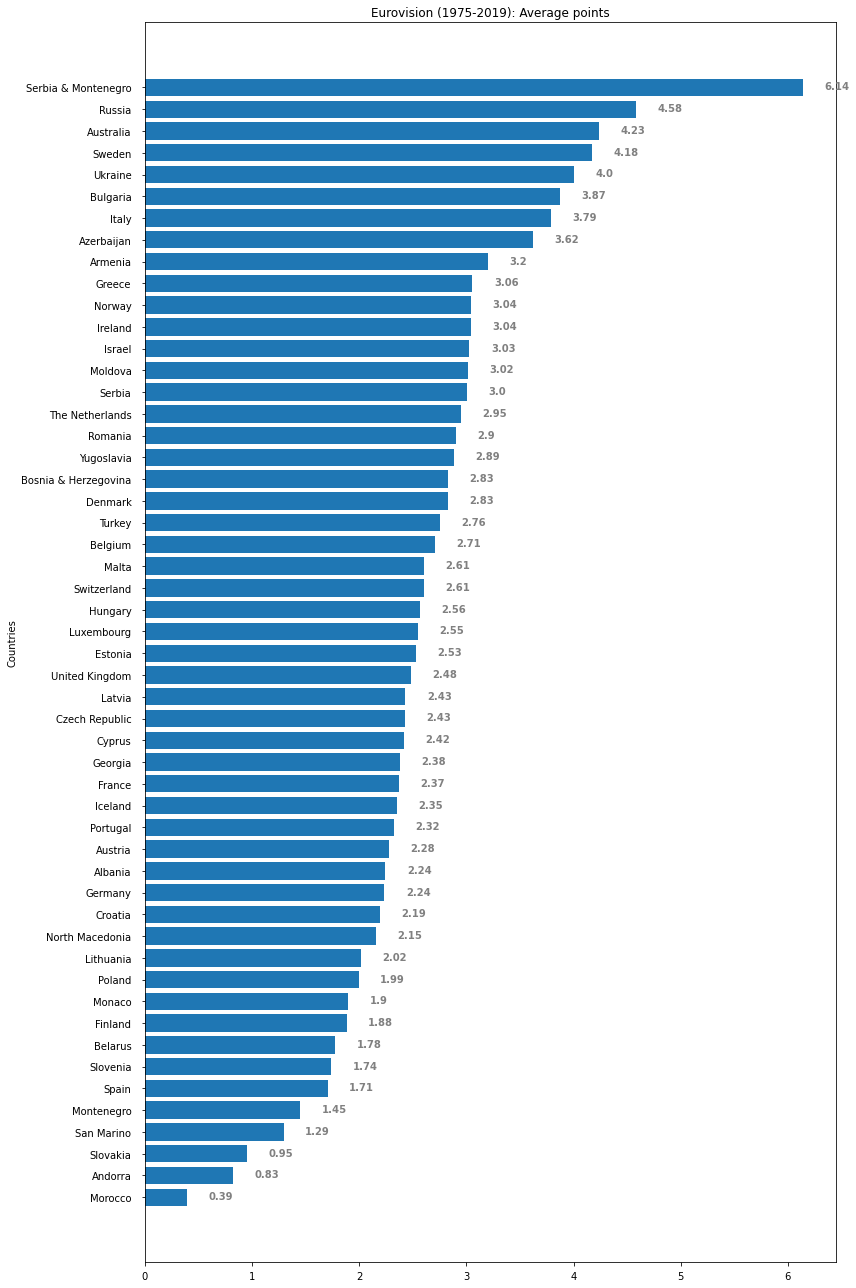

In [82]:
# Plotting average points per country
labels = df_average_points_per_country[('Points', 'mean')].index
avg_points = list(df_average_points_per_country[('Points', 'mean')])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()
ax.set_ylabel('Countries')
ax.set_title('Eurovision (1975-2019): Average points')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
fig.tight_layout()
plt.show()

In [83]:
# Average points per Year/Edition
(df_average_points_per_country_by_year) = df_esc.groupby(['To country', 'Year']).agg({'Points': ['mean']})

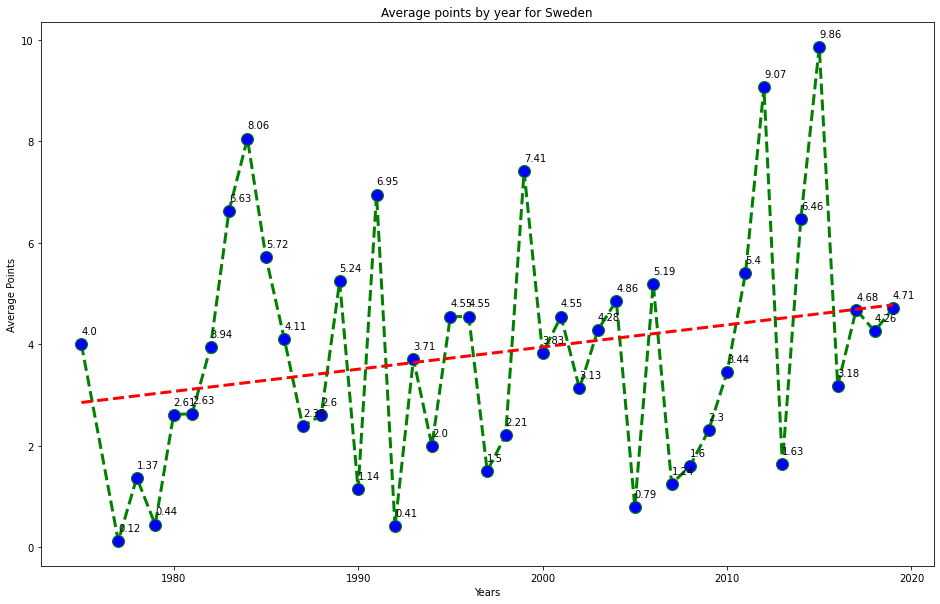

In [84]:
# Evolution of average points for highest scoring country: Sweden
country = 'Sweden'

x = df_average_points_per_country_by_year.loc[[country]].index.get_level_values('Year')
y = df_average_points_per_country_by_year.loc[[country]][('Points', 'mean')]
z = np.poly1d(np.polyfit(x, y, 1))(x)

plt.figure(figsize=(16,10))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, z,"r--", linewidth = 3)

for year, average_points in zip(x, y): 
    plt.text(year, average_points+0.2, str(round(average_points, 2)))
    
plt.xlabel('Years')
plt.ylabel('Average Points')
plt.title('Average points by year for ' + country)
plt.show()

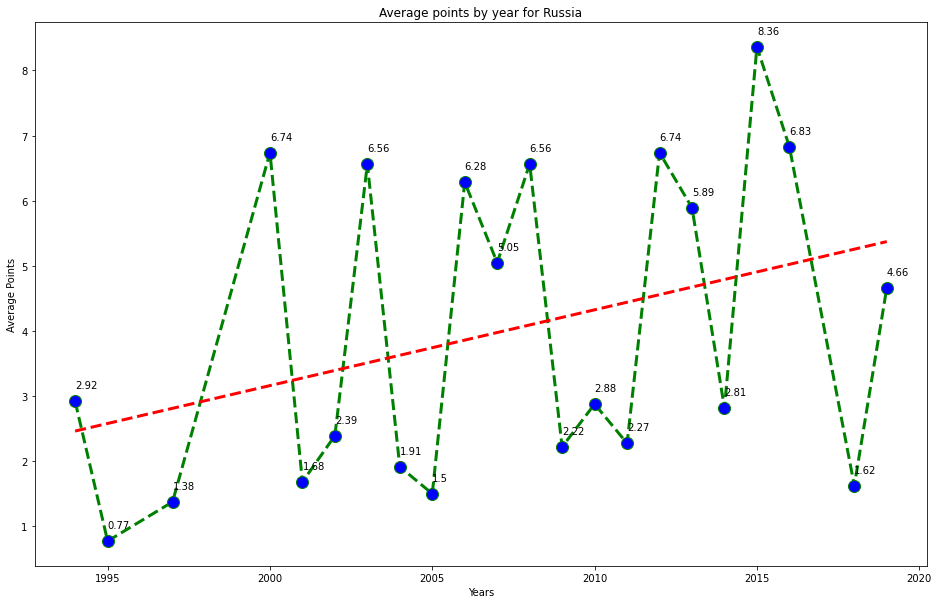

In [85]:
# Second highest scoring country: Russia
country = 'Russia'

x = df_average_points_per_country_by_year.loc[[country]].index.get_level_values('Year')
y = df_average_points_per_country_by_year.loc[[country]][('Points', 'mean')]
z = np.poly1d(np.polyfit(x, y, 1))(x)

plt.figure(figsize=(16,10))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, z,"r--", linewidth = 3)

for year, average_points in zip(x, y): 
    plt.text(year, average_points+0.2, str(round(average_points, 2)))
    
plt.xlabel('Years')
plt.ylabel('Average Points')
plt.title('Average points by year for ' + country)
plt.show()

In [86]:
# Looking at the ranking of every edition (the total amount of points received per country and the position)
df_rank = df_esc.groupby(['Edition', 'To country']).agg({'Points': ['sum']})
df_rank.columns = ['Total Points']

df_rank['Rank'] = df_rank.groupby(level=0).rank(ascending=False)
df_rank = df_rank.sort_values(['Edition','Rank'], ascending=[True, True])

In [87]:
# The winner and last place for every edition
n_winners_and_losers = 1
winners = df_rank.groupby(level=0).apply(lambda x: x.iloc[:n_winners_and_losers])
losers = df_rank.groupby(level=0).apply(lambda x: x.iloc[-n_winners_and_losers:])

df_winners_and_losers = pd.DataFrame({'Edition': winners.index.get_level_values(0)})
df_winners_and_losers.set_index('Edition', inplace=True)
df_winners_and_losers['Winning country'] = winners.index.get_level_values('To country')
df_winners_and_losers['Winning rank'] = list(winners['Rank'])
df_winners_and_losers['Winning points'] = list(winners['Total Points'])
df_winners_and_losers['Last place country'] = losers.index.get_level_values('To country')
df_winners_and_losers['Last place rank'] = list(losers['Rank'])
df_winners_and_losers['Last place points'] = list(losers['Total Points'])
df_winners_and_losers

,Winning country,Winning rank,Winning points,Last place country,Last place rank,Last place points
Edition,,,,,,
1975f,The Netherlands,1.0,152,Turkey,19.0,3
1976f,United Kingdom,1.0,164,Norway,18.0,7
1977f,France,1.0,136,Sweden,18.0,2
1978f,Israel,1.0,157,Norway,20.0,0
1979f,Israel,1.0,125,Belgium,18.5,5
...,...,...,...,...,...,...
2018sf1,Israel,1.0,283,Iceland,19.0,15
2018sf2,Norway,1.0,266,Georgia,18.0,24
2019f,The Netherlands,1.0,492,United Kingdom,26.0,14


In [88]:
# Entire ranking for every edition (separate for final and semi finals)
df_final_rank = df_rank[~df_rank.index.get_level_values('Edition').str.contains('sf')]
df_final_rank

Total Points  Rank
Edition To country                         
1975f   The Netherlands           152   1.0
        United Kingdom            138   2.0
        Italy                     115   3.0
        France                     91   4.0
        Luxembourg                 84   5.0
...                               ...   ...
2019f   Spain                      58  22.0
        Israel                     46  23.0
        Germany                    32  24.0
        Belarus                    28  25.0
        United Kingdom             14  26.0

[1032 rows x 2 columns]

In [89]:
#Analysis per semi final
df_semifinal = df_esc[df_esc.Year >= df_esc[df_esc['(semi-) final'] == 'sf1']['Year'].unique()[0]]

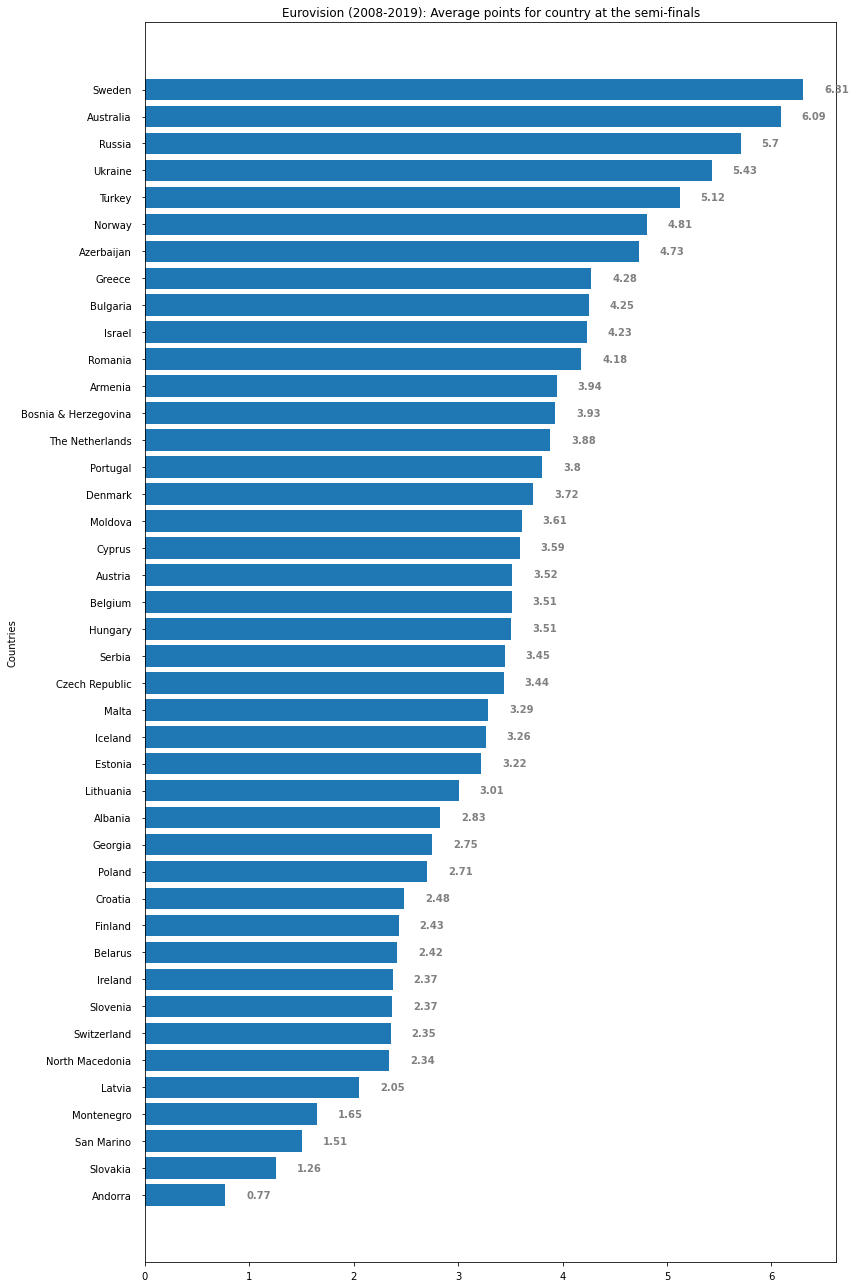

In [90]:
df_average_points_per_country_in_sf = df_semifinal.loc[(df_semifinal['(semi-) final'] == 'sf1') | (df_semifinal['(semi-) final'] == 'sf2')].groupby('To country')['Points'].mean().sort_values(ascending=False).reset_index(name='counts')
labels = df_average_points_per_country_in_sf['To country']
avg_points = list(df_average_points_per_country_in_sf['counts'])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()
ax.set_ylabel('Countries')
ax.set_title('Eurovision (2008-2019): Average points for country at the semi-finals')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
fig.tight_layout()
plt.show()

In [91]:
# Average televoting and jury points in semi finals
df_semifinal_jt = df_semifinal.loc[(df_semifinal['(semi-) final'] == 'sf1') | (df_semifinal['(semi-) final'] == 'sf2')].groupby(['To country', 'Jury or Televoting', ])['Points'].mean()

In [92]:
df1 = df_semifinal_jt.iloc[df_semifinal_jt.index.get_level_values('Jury or Televoting') == 'J'].to_frame(name='Jury Points').reset_index(level=1, drop=True)
df2 = df_semifinal_jt.iloc[df_semifinal_jt.index.get_level_values('Jury or Televoting') == 'T'].to_frame(name='Televoting Points').reset_index(level=1, drop=True)

df_average_jt = pd.merge(df1, df2, left_index=True, right_index=True)

df_average_jt['difference between Jury and Televoting points'] = abs(df_average_jt['Jury Points'] - df_average_jt['Televoting Points'])
df_average_jt.sort_values(by='difference between Jury and Televoting points', ascending=False)

,Jury Points,Televoting Points,difference between Jury and Televoting points
To country,,,
Bulgaria,3.486034,6.491803,3.005770
Portugal,3.284091,6.153846,2.869755
Greece,4.961702,2.262500,2.699202
Malta,3.940426,1.375000,2.565426
Australia,7.303797,4.873418,2.430380
Sweden,6.852792,4.516667,2.336125
Cyprus,2.986301,5.237500,2.251199
Hungary,2.930876,5.101266,2.170390
Poland,2.168367,4.037975,1.869607


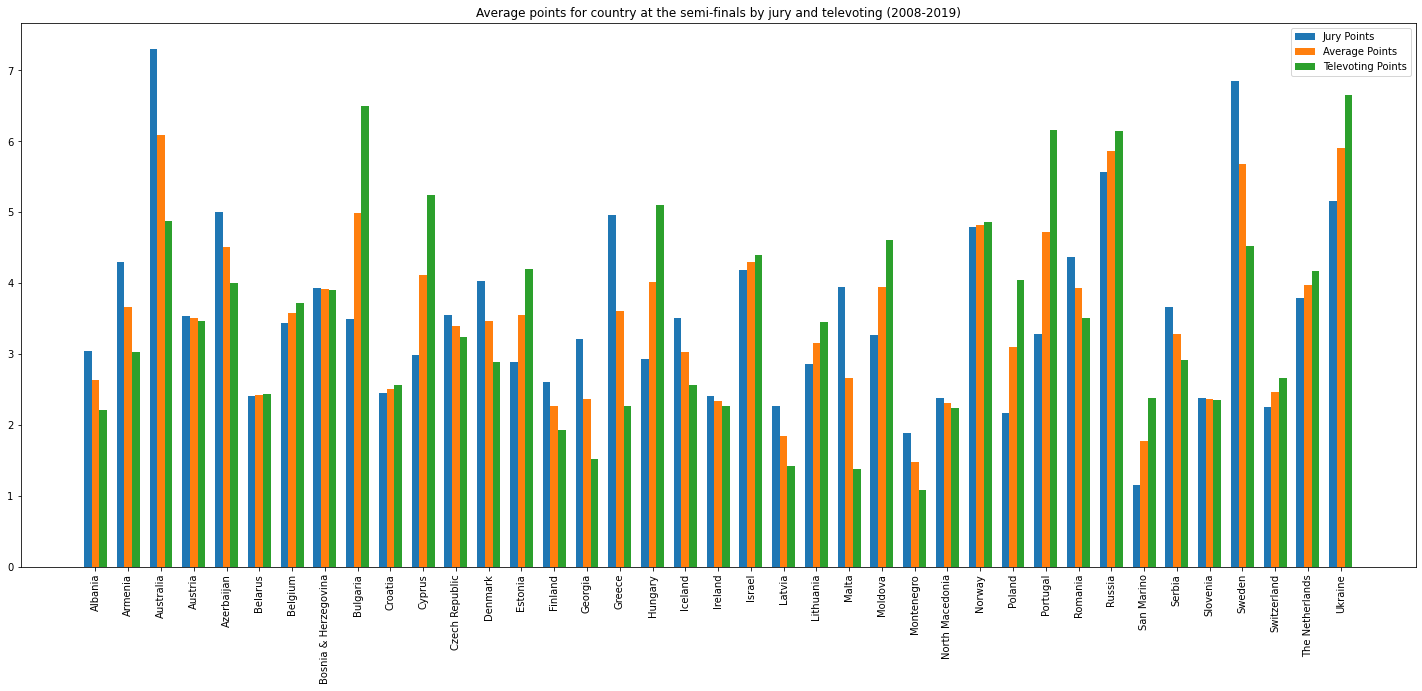

In [93]:
#Plotting the average points from jury and televoting in semi-finals (2008-2019)
plt.figure(figsize=(25,10))

countries = df_average_jt.index
jury_points = df_average_jt['Jury Points']
avg_points = (df_average_jt['Jury Points'] + df_average_jt['Televoting Points']) / 2
televoting_points = df_average_jt['Televoting Points']

def subcategorybar(countries, vals, width=0.8):
    n = len(vals)
    _countries = np.arange(len(countries))
    for i in range(n):
        plt.bar(_countries - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
    plt.xticks(_countries, countries, rotation='vertical')
    plt.legend(['Jury Points', 'Average Points', 'Televoting Points'])
    plt.title('Average points for country at the semi-finals by jury and televoting (2008-2019)')
    
subcategorybar(countries, [jury_points, avg_points, televoting_points], 0.7)

plt.show()

In [94]:
# Average points in the final (editions with semi-finals, 2008-2019)
df_average_points_final = df_semifinal[df_semifinal['(semi-) final'] == 'f'].groupby('To country')['Points'].mean().sort_values(ascending=False).reset_index(name='counts')

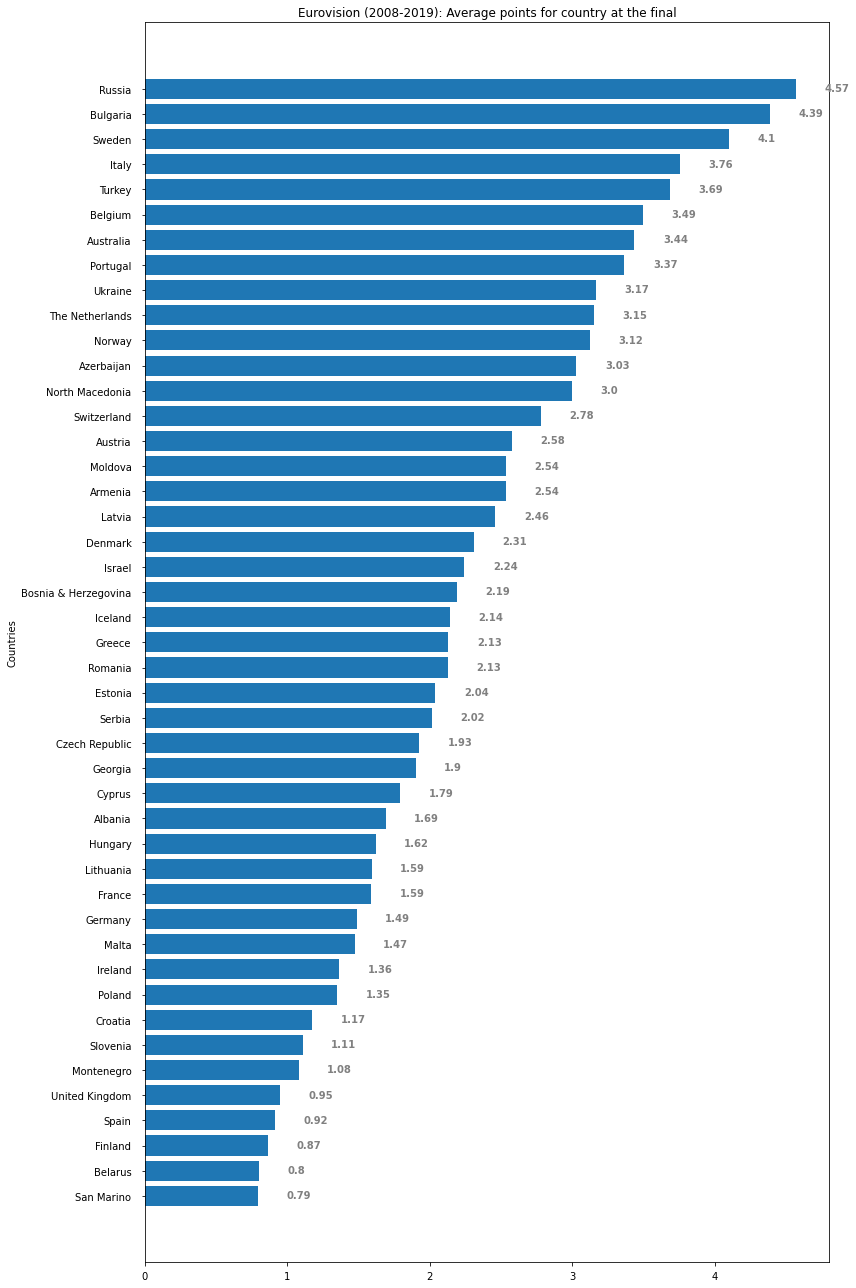

In [95]:
#Plotting average points in finals (2008-2019)
labels = df_average_points_final['To country']
avg_points = list(df_average_points_final['counts'])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()

ax.set_ylabel('Countries')
ax.set_title('Eurovision (2008-2019): Average points for country at the final')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

fig.tight_layout()

plt.show()

In [96]:
df_jt_f = df_semifinal[df_semifinal['(semi-) final'] == 'f'].groupby(['To country', 'Jury or Televoting', ])['Points'].mean()

In [97]:
df1 = df_jt_f.iloc[df_jt_f.index.get_level_values('Jury or Televoting') == 'J'].to_frame(name='Jury Points').reset_index(level=1, drop=True)
df2 = df_jt_f.iloc[df_jt_f.index.get_level_values('Jury or Televoting') == 'T'].to_frame(name='Televoting Points').reset_index(level=1, drop=True)

df_average_jt_f = pd.merge(df1, df2, left_index=True, right_index=True)

df_average_jt_f['difference between Jury and Televoting points'] = abs(df_average_jt_f['Jury Points'] - df_average_jt_f['Televoting Points'])
df_average_jt_f.sort_values(by='difference between Jury and Televoting points', ascending=False)

,Jury Points,Televoting Points,difference between Jury and Televoting points
To country,,,
Romania,1.745810,5.463415,3.717605
Switzerland,1.940678,5.250000,3.309322
Russia,4.030075,7.207317,3.177242
Iceland,1.833333,4.575000,2.741667
Moldova,1.939929,4.566265,2.626336
Poland,0.582915,3.207317,2.624403
Australia,4.586207,2.012195,2.574012
Sweden,4.769752,2.304878,2.464874
North Macedonia,3.777778,1.425000,2.352778


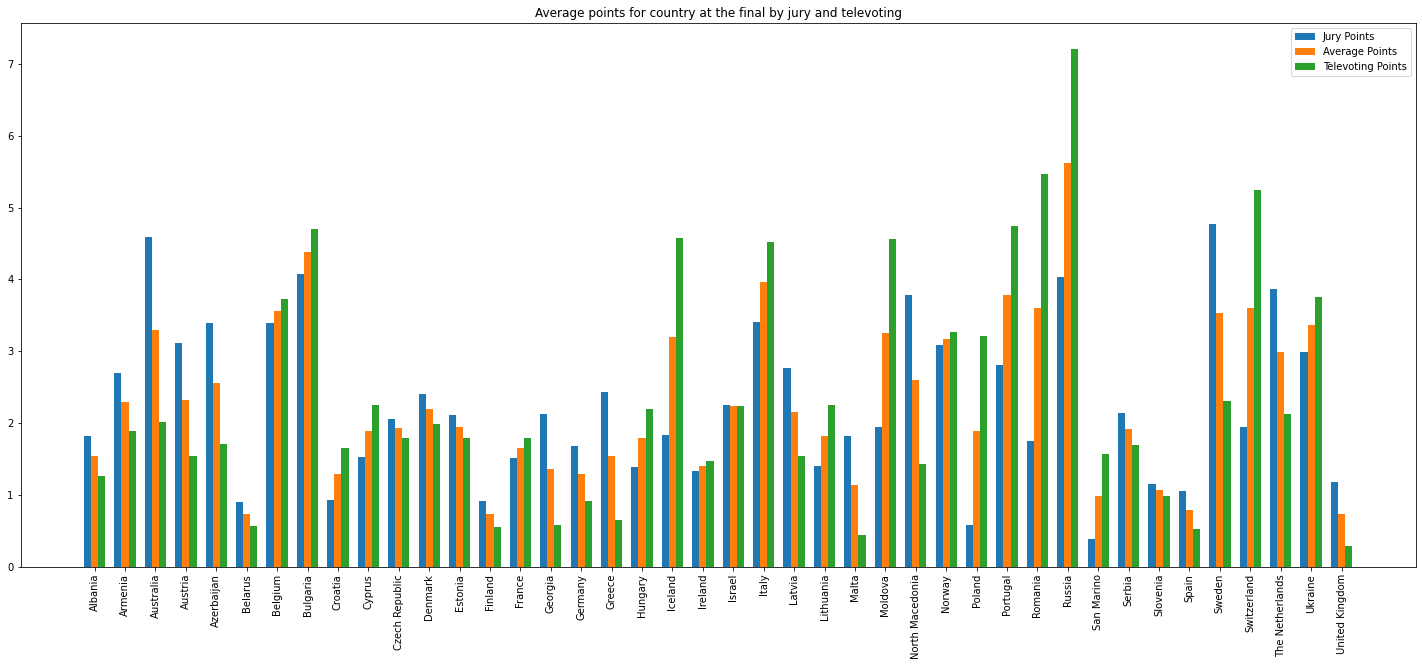

In [98]:
#Plotting average points by jury and televoting final (2008-2019)
plt.figure(figsize=(25,10))

countries = df_average_jt_f.index
jury_points = df_average_jt_f['Jury Points']
avg_points = (df_average_jt_f['Jury Points'] + df_average_jt_f['Televoting Points']) / 2
televoting_points = df_average_jt_f['Televoting Points']

def subcategorybar(countries, vals, width=0.8):
    n = len(vals)
    _countries = np.arange(len(countries))
    for i in range(n):
        plt.bar(_countries - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
    plt.xticks(_countries, countries, rotation='vertical')
    plt.legend(['Jury Points', 'Average Points', 'Televoting Points'])
    plt.title('Average points for country at the final by jury and televoting')
    
subcategorybar(countries, [jury_points, avg_points, televoting_points], 0.7)

plt.show()

# Cluster analysis
### Voting blocks

## Cluster analysis of all data (1975-2019) - hierarchical clustering

In [99]:
df_averagepoints = df_esc.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_averagepoints.head(n=10)

,,Points
,,mean
From country,To country,
Austria,Serbia & Montenegro,12.000000
Switzerland,Serbia & Montenegro,12.000000
Morocco,Turkey,12.000000
Croatia,Serbia & Montenegro,12.000000
Azerbaijan,Turkey,12.000000
Turkey,Azerbaijan,12.000000
Moldova,Romania,11.681818
Bosnia & Herzegovina,Serbia & Montenegro,11.333333


In [100]:
#Transposing the data frame
dist_all = df_averagepoints.pivot_table(index='From country', columns='To country', values='Points')
dist_all.head()

mean                                                   \
To country     Albania Andorra   Armenia Australia   Austria Azerbaijan   
From country                                                              
Albania            NaN     1.5  1.478261  4.230769  0.882353   3.833333   
Andorra       0.857143     NaN  0.428571       NaN  2.666667   5.000000   
Armenia       0.300000     0.0       NaN  1.090909  1.875000   0.115385   
Australia     0.000000     NaN  1.375000       NaN  1.571429   0.800000   
Austria       3.750000     0.0  2.533333  3.333333       NaN   2.647059   

                                                                 ...           \
To country     Belarus   Belgium Bosnia & Herzegovina  Bulgaria  ... Slovakia   
From country                                                     ...            
Albania       0.684211  2.000000             6.250000  5.500000  ...      2.0   
Andorra       0.000000  1.333333             0.100000  0.000000  ...      NaN   
Armenia       4.071429  2.117647             1.727273  2.214286  ...      NaN   
Australia     0.888889  5.833333                  NaN  6.125000  ...      NaN   
Austria       1.388889  1.974359             6.352941  5.071429  ...      1.0   

                                                                         \
To country    Slovenia      Spain    Sweden Switzerland The Netherlands   
From country                                                              
Albania       1.411765   2.750000  3.423077    2.421053        2.000000   
Andorra       1.333333  10.000000  4.000000    1.500000        3.166667   
Armenia       0.428571   0.764706  4.166667    3.000000        3.100000   
Australia     1.357143   1.555556  7.428571    1.600000        1.909091   
Austria       1.666667   1.619048  4.250000    4.076923        3.733333   

                                                            
To country      Turkey   Ukraine United Kingdom Yugoslavia  
From country                                                
Albania       9.416667  1.583333       1.550000        NaN  
Andorra       1.666667  6.125000       1.000000        NaN  
Armenia       1.600000  6.000000       0.882353        NaN  
Australia          NaN  2.500000       3.222222        NaN  
Austria       2.592593  1.764706       4.000000        2.0  

[5 rows x 52 columns]

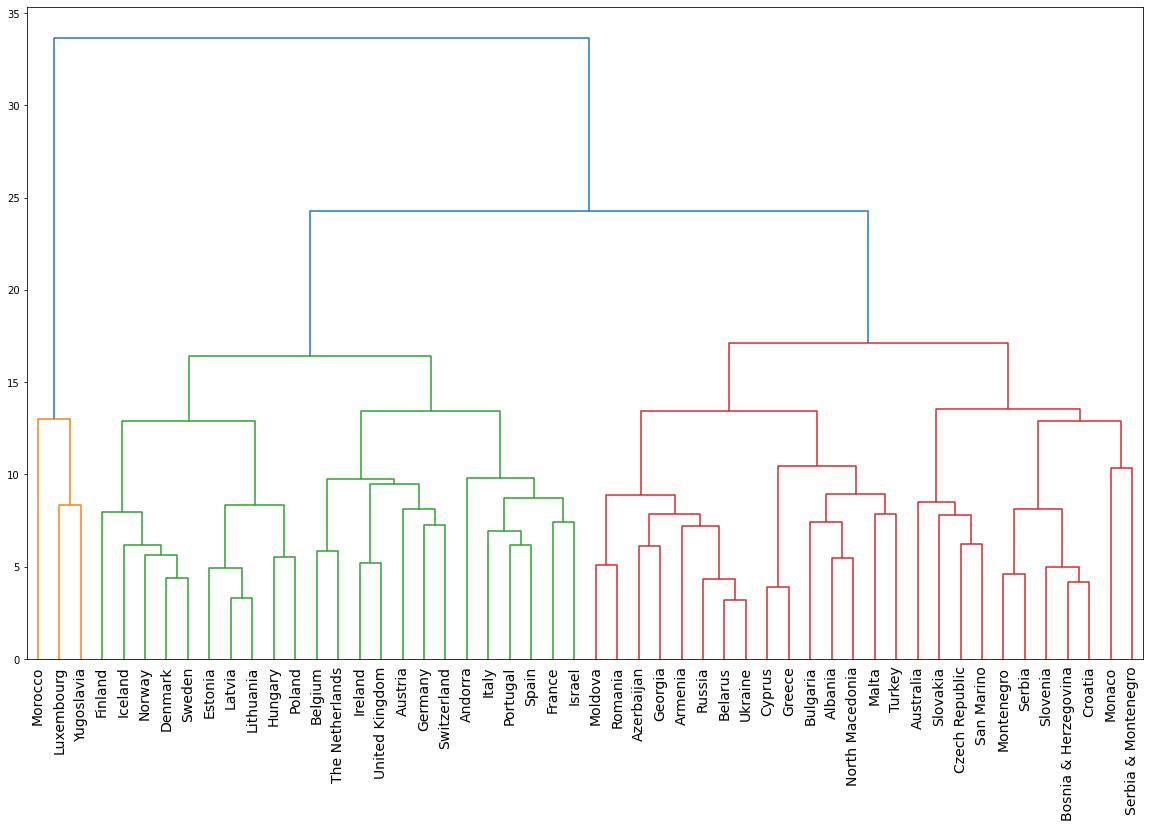

In [101]:
#Nas replaced by 12 - assuming that if countries could vote for themselves, they would give 12 points
dist_all.fillna(12, inplace=True)
df_scaledall = whiten(dist_all.to_numpy())
#Using linkage method ward
mergings = linkage(df_scaledall, method='ward')

# Threshold can be changed (default is 0.7)
plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_all.index), color_threshold=0.6*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

## Only semi-finals

In [102]:
df_sf = df_esc[(df_esc['(semi-) final'] == 'sf1') | (df_esc['(semi-) final'] == 'sf2')].drop(['Year', '(semi-) final', 'Edition', 'Jury or Televoting'], axis=1)
df_sf.head(n=10)

,From country,To country,Points,From country_iso2,To country_iso2
22340,Andorra,Armenia,3,AD,AM
22341,Andorra,Azerbaijan,8,AD,AZ
22342,Andorra,Belgium,0,AD,BE
22343,Andorra,Bosnia & Herzegovina,0,AD,BA
22344,Andorra,Estonia,0,AD,EE
22345,Andorra,Finland,12,AD,FI
22346,Andorra,Greece,5,AD,GR
22347,Andorra,Ireland,0,AD,IE
22348,Andorra,Israel,7,AD,IL
22349,Andorra,Moldova,1,AD,MD


In [103]:
df_sf_average = df_sf.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_sf_average.head()

,,Points
,,mean
From country,To country,
Slovakia,Azerbaijan,12.0
Turkey,Bosnia & Herzegovina,12.0
Belgium,Turkey,12.0
Spain,Andorra,12.0
Czech Republic,Ukraine,12.0


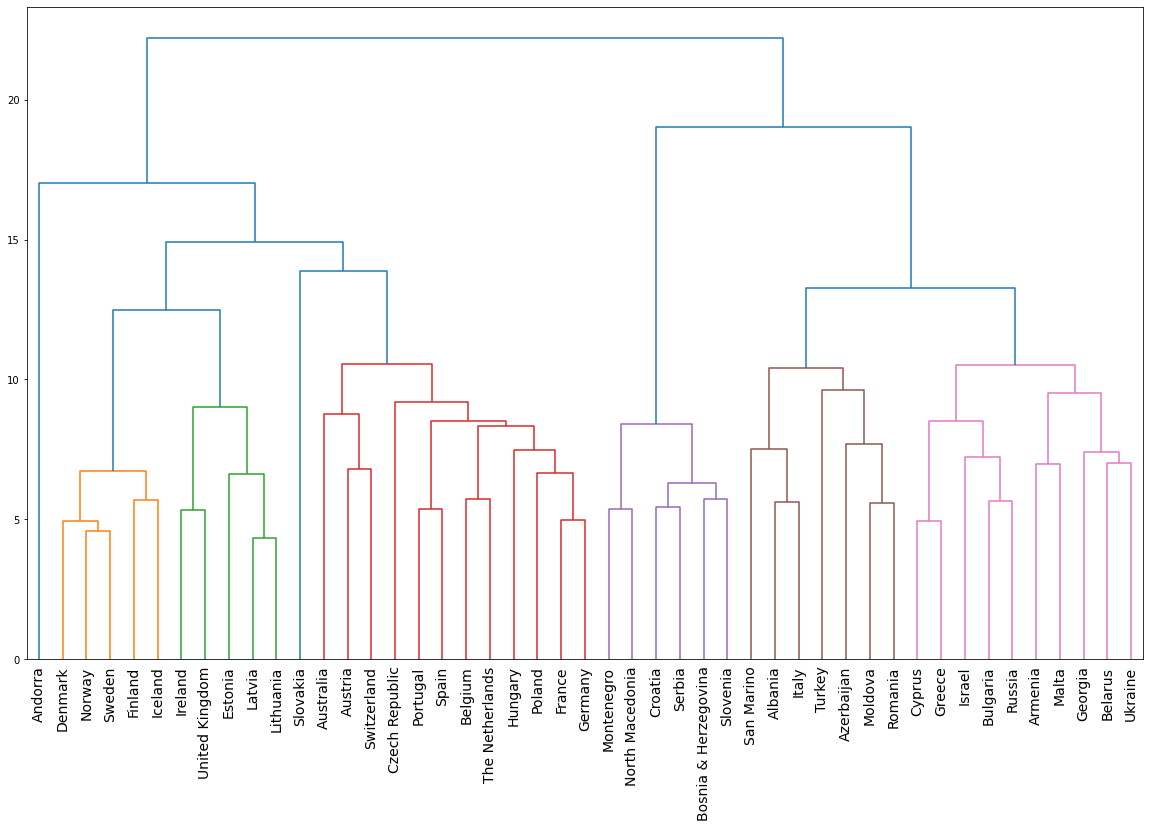

In [104]:
dist_sf = df_sf_average.pivot_table(index='From country', columns='To country', values='Points')

dist_sf.fillna(12, inplace=True)
df_scaledsf = whiten(dist_sf.to_numpy())
mergings = linkage(df_scaledsf, method='ward')

plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_sf.index), color_threshold=0.5*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

## Only jury votes

In [105]:
df_jury = df_esc[df_esc['Jury or Televoting'] == 'J'].drop(['Year', '(semi-) final', 'Edition', 'Jury or Televoting'], axis=1)
df_jury.head()

,From country,To country,Points,From country_iso2,To country_iso2
1,Belgium,Finland,0,BE,FI
2,Belgium,France,2,BE,FR
3,Belgium,Germany,0,BE,DE
4,Belgium,Ireland,12,BE,IE
5,Belgium,Israel,1,BE,IL


In [106]:
df_jury_average = df_jury.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_jury_average.head()

,,Points
,,mean
From country,To country,
Turkey,Azerbaijan,12.0
Croatia,Serbia & Montenegro,12.0
Azerbaijan,Turkey,12.0
Switzerland,Serbia & Montenegro,12.0
Morocco,Turkey,12.0


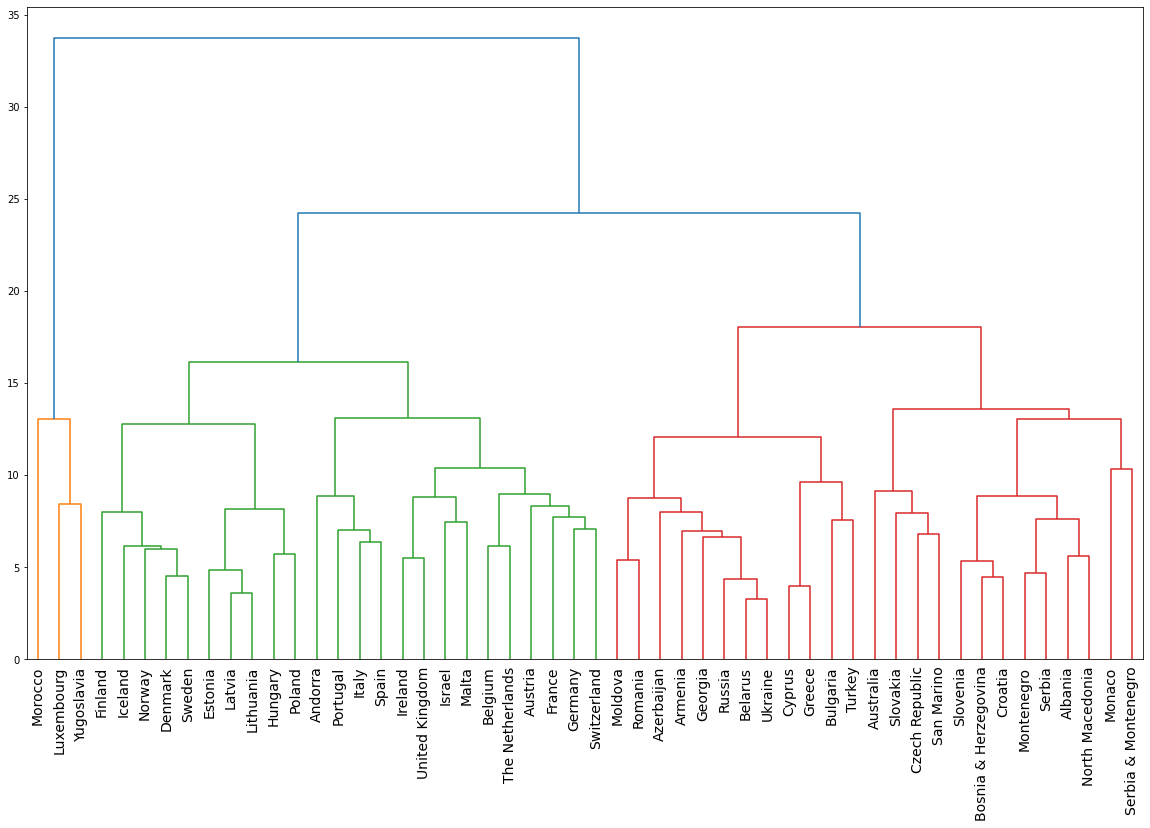

In [107]:
dist_jury = df_jury_average.pivot_table(index='From country', columns='To country', values='Points')

dist_jury.fillna(12, inplace=True)
df_scaledj = whiten(dist_jury.to_numpy())
mergings = linkage(df_scaledj, method='ward')

plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_jury.index), color_threshold=0.6*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

## Only televoting

In [108]:
df_tv = df_esc[df_esc['Jury or Televoting'] == 'T'].drop(['Year', '(semi-) final', 'Edition', 'Jury or Televoting'], axis=1)
df_tv.head()

,From country,To country,Points,From country_iso2,To country_iso2
36352,Albania,Armenia,2,AL,AM
36353,Albania,Australia,12,AL,AU
36354,Albania,Austria,0,AL,AT
36355,Albania,Azerbaijan,0,AL,AZ
36356,Albania,Belgium,0,AL,BE


In [109]:
df_tv_average = df_tv.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_tv_average.head()

Points
                                    mean
From country To country                 
Latvia       Russia                 12.0
Montenegro   Serbia                 12.0
             Bosnia & Herzegovina   12.0
Cyprus       Greece                 12.0
Greece       Cyprus                 12.0

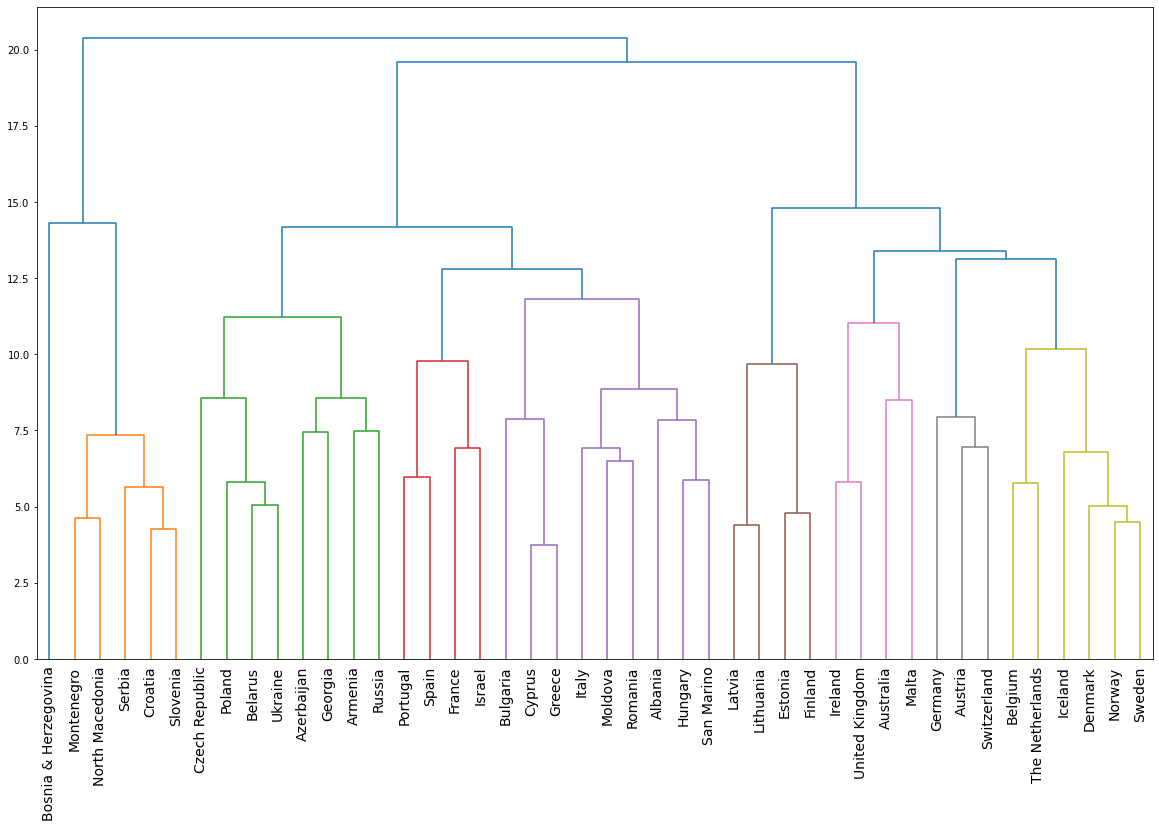

In [110]:
dist_tv = df_tv_average.pivot_table(index='From country', columns='To country', values='Points')

dist_tv.fillna(12, inplace=True)
df_scaledtv = whiten(dist_tv.to_numpy())
mergings = linkage(df_scaledtv, method='ward')

plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_tv.index), color_threshold=0.6*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

# Setup graph

### Graph based on voting

In [12]:
#set node i
df_features['node'] = df_features.index
nodes  = df_features.loc[:, df_features.columns != 'country_border_code']

#create country border edges
edges = pd.DataFrame()
From = []
To = []
pos = []

df_features['pos'] = ""
#reformat df to create edges/nodes
for index, row in df_features.iterrows():
    #create position from lat and lon
    row['pos'] = [float(row['lat']),float(row['lon'])]
    
    #extract all country edges
    for i in range(len(row['country_border_code'])):
        _from = row['node']
        _to = row['country_border_code'][i]
        
        #remove edges to countries outside the graph  
        if(_to in df_features.index.values):
            From.append(_from)
            To.append(_to)


#edges['to'] = To
#edges['from'] = From

#pos = nodes.pos.to_dict()

#G = nx.from_pandas_edgelist(edges,'from','to') #networkx does not add duplicate edges

#create node properties
#for prop in nodes.columns:
    #nx.set_node_attributes(G, pd.Series(nodes[prop], index=nodes.node).to_dict(),prop)

AttributeError: 'DataFrame' object has no attribute 'pos'

#### Only create edges if average point over years > 3 

In [38]:
#set node i
df_features['node'] = df_features.index
nodes  = df_features.loc[:, df_features.columns != 'country_border_code']

In [13]:
# Dataframe where mean for all years etc is calculated
df_avg = df_esc.groupby(['To country', 'From country'])['Points'].mean().reset_index()
df_avg['Points'] = df_avg['Points'].round()
df_avg['Points'].value_counts()

2.0     581
1.0     537
3.0     440
0.0     282
4.0     237
5.0     125
6.0      91
7.0      50
8.0      33
9.0      26
10.0     13
11.0      9
12.0      7
Name: Points, dtype: int64

In [14]:
Graf = nx.from_pandas_edgelist(df_avg[df_avg['Points'] > 3], 'From country', 'To country', ['Points'])

In [15]:
Graf.nodes()

NodeView(('Austria', 'Albania', 'Azerbaijan', 'Bosnia & Herzegovina', 'Croatia', 'Greece', 'Italy', 'Montenegro', 'North Macedonia', 'San Marino', 'Serbia & Montenegro', 'Switzerland', 'Turkey', 'Czech Republic', 'Andorra', 'Spain', 'Belarus', 'Armenia', 'Belgium', 'Bulgaria', 'Cyprus', 'France', 'Georgia', 'Israel', 'Moldova', 'Poland', 'Russia', 'Slovakia', 'The Netherlands', 'Ukraine', 'Australia', 'Denmark', 'Finland', 'Germany', 'Hungary', 'Iceland', 'Ireland', 'Latvia', 'Lithuania', 'Malta', 'Norway', 'Serbia', 'Sweden', 'United Kingdom', 'Romania', 'Portugal', 'Monaco', 'Slovenia', 'Estonia', 'Yugoslavia', 'Luxembourg', 'Morocco'))

In [16]:
Graf.edges.data()

EdgeDataView([('Austria', 'Albania', {'Points': 4.0}), ('Austria', 'Bulgaria', {'Points': 5.0}), ('Austria', 'Bosnia & Herzegovina', {'Points': 6.0}), ('Austria', 'Croatia', {'Points': 4.0}), ('Austria', 'Czech Republic', {'Points': 5.0}), ('Austria', 'Ireland', {'Points': 5.0}), ('Austria', 'Italy', {'Points': 4.0}), ('Austria', 'Poland', {'Points': 4.0}), ('Austria', 'Romania', {'Points': 4.0}), ('Austria', 'Russia', {'Points': 4.0}), ('Austria', 'Serbia', {'Points': 5.0}), ('Austria', 'Serbia & Montenegro', {'Points': 12.0}), ('Austria', 'Sweden', {'Points': 4.0}), ('Austria', 'Switzerland', {'Points': 4.0}), ('Austria', 'The Netherlands', {'Points': 4.0}), ('Austria', 'United Kingdom', {'Points': 4.0}), ('Albania', 'Azerbaijan', {'Points': 4.0}), ('Albania', 'Bosnia & Herzegovina', {'Points': 6.0}), ('Albania', 'Croatia', {'Points': 5.0}), ('Albania', 'Greece', {'Points': 9.0}), ('Albania', 'Italy', {'Points': 10.0}), ('Albania', 'Montenegro', {'Points': 6.0}), ('Albania', 'North M

In [17]:
#Louvain communities, unweighted (so only concentration of relationships is taken in consideration)
#NOTE: if this doesn't work, try updating the networkx package!!
communities_t = nx.algorithms.community.louvain_communities(Graf, resolution=0, seed=123)
coms_t = list()
for i in communities_t:
    i = list(i)
    coms_t.append(i)
df_coms_t = pd.DataFrame([coms_t]).transpose().reset_index().rename(columns={'index': 'number', 0: 'community'})
df_coms_t['number'] = df_coms_t['number']+1
df_coms_t

,number,community
0,1,"[Serbia, Russia, Andorra, Morocco, France, Bel..."


In [18]:
# Calculate modularity for the achieved communities
nx.community.modularity(Graf,communities_t,resolution=0)

1.0

Maximum modularity is achieved by having 1 entire connected graph

#### Create a graph only for televoting, over all years

In [19]:
Graph = nx.from_pandas_edgelist(df_esc[df_esc['Jury or Televoting'] == 'T'], 'From country', 'To country', ['Points', '(semi-) final', 'Year', 'Jury or Televoting'])

In [20]:
Graph.nodes()

NodeView(('Albania', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'France', 'Georgia', 'Germany', 'Hungary', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Poland', 'Russia', 'Serbia', 'Spain', 'Sweden', 'The Netherlands', 'Ukraine', 'United Kingdom', 'Belarus', 'Bosnia & Herzegovina', 'Denmark', 'Estonia', 'North Macedonia', 'Finland', 'Greece', 'Iceland', 'Ireland', 'Moldova', 'Montenegro', 'Norway', 'San Marino', 'Slovenia', 'Switzerland', 'Portugal', 'Romania'))

In [21]:
Graph.edges.data()

EdgeDataView([('Albania', 'Armenia', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'Australia', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'Austria', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'Azerbaijan', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'Belgium', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'Bulgaria', {'Points': 5, '(semi-) final': 'sf1', 'Year': 2018, 'Jury or Televoting': 'T'}), ('Albania', 'Croatia', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'Cyprus', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'Czech Republic', {'Points': 0, '(semi-) final': 'f', 'Year': 2019, 'Jury or Televoting': 'T'}), ('Albania', 'France', {'Points': 0, '(semi-) final': '

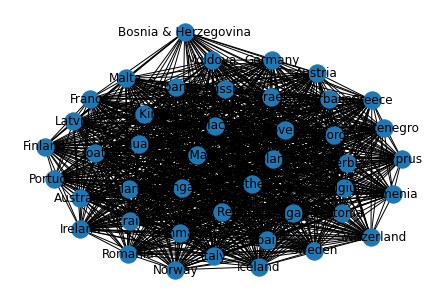

In [22]:
nx.draw(Graph, with_labels = True)

#### Create a graph with the average score of all years

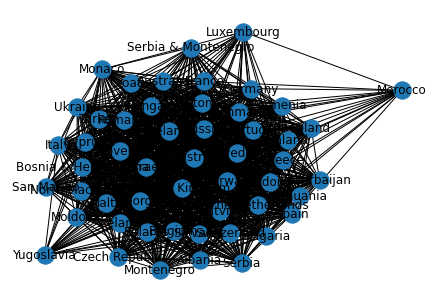

In [23]:
# Create graph
avg_G = nx.from_pandas_edgelist(df_avg, 'From country', 'To country', 'Points')
nx.draw(avg_G, with_labels=True)

In [24]:
avg_G.nodes()

NodeView(('Andorra', 'Albania', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia & Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Serbia & Montenegro', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'The Netherlands', 'Turkey', 'Ukraine', 'United Kingdom', 'Luxembourg', 'Morocco', 'Yugoslavia'))

In [25]:
avg_G.edges.data()

EdgeDataView([('Andorra', 'Albania', {'Points': 2.0}), ('Andorra', 'Armenia', {'Points': 0.0}), ('Andorra', 'Austria', {'Points': 3.0}), ('Andorra', 'Azerbaijan', {'Points': 5.0}), ('Andorra', 'Belarus', {'Points': 0.0}), ('Andorra', 'Belgium', {'Points': 1.0}), ('Andorra', 'Bosnia & Herzegovina', {'Points': 0.0}), ('Andorra', 'Bulgaria', {'Points': 0.0}), ('Andorra', 'Croatia', {'Points': 0.0}), ('Andorra', 'Cyprus', {'Points': 1.0}), ('Andorra', 'Czech Republic', {'Points': 0.0}), ('Andorra', 'Denmark', {'Points': 3.0}), ('Andorra', 'Estonia', {'Points': 0.0}), ('Andorra', 'Finland', {'Points': 5.0}), ('Andorra', 'France', {'Points': 4.0}), ('Andorra', 'Georgia', {'Points': 0.0}), ('Andorra', 'Germany', {'Points': 1.0}), ('Andorra', 'Greece', {'Points': 4.0}), ('Andorra', 'Hungary', {'Points': 4.0}), ('Andorra', 'Iceland', {'Points': 3.0}), ('Andorra', 'Ireland', {'Points': 1.0}), ('Andorra', 'Israel', {'Points': 5.0}), ('Andorra', 'Latvia', {'Points': 2.0}), ('Andorra', 'Lithuania',

In [26]:
#Louvain communities, weighted
communities = community.louvain_communities(avg_G, resolution=0, weight='Points', seed=123)
coms = list()
for i in communities:
    i = list(i)
    coms.append(i)
df_coms = pd.DataFrame([coms]).transpose().reset_index().rename(columns={'index': 'number', 0: 'community'})
df_coms['number'] = df_coms['number']+1
df_coms

,number,community
0,1,"[Serbia, Russia, Andorra, Morocco, France, Bel..."


In [27]:
# Calculate modularity for the achieved communities
community.modularity(avg_G,communities, weight='Points',resolution=0)

1.0

In [28]:
# Attach the communities to df_features dataframe
df_features['community'] = ""
df_features['com_nr'] = ""
for index, row in df_features.iterrows():
    for i, r in df_coms.iterrows():
        if row['Name'] in r['community']:
            row['community'] = r['community']
            row['com_nr'] = r['number']
            
        else:
            continue
df_features

,Name,continent,langoff_1,lat,lon,colonizer1,Religion,Immigrants,country_border_code,UTC_offset,node,pos,community,com_nr
Code,,,,,,,,,,,,,,
AL,Albania,Europe,Albanian,41.33333,19.81667,TUR,Islam,Turkey,"[GR, ME, MK, RS]",+0200,AL,"[41.33333, 19.81667]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
AD,Andorra,Europe,Catalan,42.5,1.5,.,Catholic,Spain,"[FR, ES]",+0200,AD,"[42.5, 1.5]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
AM,Armenia,Asia,Armenian,40.18333,44.5,TUR,Orthodox,Azerbaijan,"[AZ, GE, IR, TR]",+0400,AM,"[40.18333, 44.5]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
AU,Australia,Pacific,English,-33.88334,151.1667,GBR,Protestant,United Kingdom,[nan],+1030,AU,"[-33.88334, 151.1667]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
AT,Austria,Europe,German,48.21667,16.36667,.,Catholic,Germany,"[CZ, DE, HU, IT, LI, SK, SI, CH]",+0200,AT,"[48.21667, 16.36667]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
AZ,Azerbaijan,Asia,Azeri,40.36666,49.88334,RUS,Islam,Armenia,"[AM, GE, IR, RU, TR]",+0400,AZ,"[40.36666, 49.88334]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
BY,Belarus,Europe,Belarussian,53.85,27.5,RUS,Orthodox,Russia,"[LV, LT, PL, RU, UA]",+0300,BY,"[53.85, 27.5]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
BE,Belgium,Europe,Dutch,50.83333,4.35,.,Catholic,Italy,"[FR, DE, LU, NL]",+0200,BE,"[50.83333, 4.35]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1
BA,Bosnia and Herzegovina,Europe,Serbo-Croatian,43.86666,18.43333,TUR,Islam,Syria,"[HR, ME, RS]",+0200,BA,"[43.86666, 18.43333]",,


In [29]:
# Calculate the betweenness of all countries
bet = nx.betweenness_centrality(avg_G, weight='Points', seed=123)
ctrs = list()
vls = list()
for i in bet.keys():
    ctrs.append(i)
    vls.append(bet[i])
df_bet = pd.DataFrame(vls, ctrs).reset_index().rename(columns={'index': 'Name', 0: 'betweenness'})
df_bet

,Name,betweenness
0,Andorra,229.448761
1,Albania,0.019692
2,Armenia,179.756436
3,Australia,0.000000
4,Austria,1.280036
5,Azerbaijan,2.157536
6,Belarus,0.115496
7,Belgium,0.038188
8,Bosnia & Herzegovina,11.102391
9,Bulgaria,2.340511


In [30]:
# Perform LPA
list(community.asyn_lpa_communities(avg_G, weight='Points', seed=123))

[{'Albania',
  'Andorra',
  'Armenia',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Belarus',
  'Belgium',
  'Bosnia & Herzegovina',
  'Bulgaria',
  'Croatia',
  'Cyprus',
  'Czech Republic',
  'Denmark',
  'Estonia',
  'Finland',
  'France',
  'Georgia',
  'Germany',
  'Greece',
  'Hungary',
  'Iceland',
  'Ireland',
  'Israel',
  'Italy',
  'Latvia',
  'Lithuania',
  'Luxembourg',
  'Malta',
  'Moldova',
  'Monaco',
  'Montenegro',
  'Morocco',
  'North Macedonia',
  'Norway',
  'Poland',
  'Portugal',
  'Romania',
  'Russia',
  'San Marino',
  'Serbia',
  'Serbia & Montenegro',
  'Slovakia',
  'Slovenia',
  'Spain',
  'Sweden',
  'Switzerland',
  'The Netherlands',
  'Turkey',
  'Ukraine',
  'United Kingdom',
  'Yugoslavia'}]

In [31]:
# Attach betweenness feature column to df_features dataframe
df_features = df_features.merge(df_bet, left_on='Name', right_on='Name')
df_features

,Name,continent,langoff_1,lat,lon,colonizer1,Religion,Immigrants,country_border_code,UTC_offset,node,pos,community,com_nr,betweenness
0,Albania,Europe,Albanian,41.33333,19.81667,TUR,Islam,Turkey,"[GR, ME, MK, RS]",+0200,AL,"[41.33333, 19.81667]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,0.019692
1,Andorra,Europe,Catalan,42.5,1.5,.,Catholic,Spain,"[FR, ES]",+0200,AD,"[42.5, 1.5]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,229.448761
2,Armenia,Asia,Armenian,40.18333,44.5,TUR,Orthodox,Azerbaijan,"[AZ, GE, IR, TR]",+0400,AM,"[40.18333, 44.5]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,179.756436
3,Australia,Pacific,English,-33.88334,151.1667,GBR,Protestant,United Kingdom,[nan],+1030,AU,"[-33.88334, 151.1667]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,0.000000
4,Austria,Europe,German,48.21667,16.36667,.,Catholic,Germany,"[CZ, DE, HU, IT, LI, SK, SI, CH]",+0200,AT,"[48.21667, 16.36667]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,1.280036
5,Azerbaijan,Asia,Azeri,40.36666,49.88334,RUS,Islam,Armenia,"[AM, GE, IR, RU, TR]",+0400,AZ,"[40.36666, 49.88334]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,2.157536
6,Belarus,Europe,Belarussian,53.85,27.5,RUS,Orthodox,Russia,"[LV, LT, PL, RU, UA]",+0300,BY,"[53.85, 27.5]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,0.115496
7,Belgium,Europe,Dutch,50.83333,4.35,.,Catholic,Italy,"[FR, DE, LU, NL]",+0200,BE,"[50.83333, 4.35]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,0.038188
8,Bulgaria,Europe,Bulgarian,42.66667,23.3,TUR,Orthodox,Russia,"[GR, MK, RO, RS, TR]",+0300,BG,"[42.66667, 23.3]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,2.340511
9,Croatia,Europe,Serbo-Croatian,45.8,15.96667,AUT,Catholic,Bosnia,"[BA, HU, ME, RS, SI]",+0200,HR,"[45.8, 15.96667]","[Serbia, Russia, Andorra, Morocco, France, Bel...",1,12.113713


## neo4j 

In [48]:
# Connect to neo4j database
f=open("authentication/neo4j.txt","r")
lines=f.readlines()
user=lines[0].replace('\n','')
pwd=lines[1].replace('\n','')
http_port = lines[2]
f.close()

graph = Graph(http_port, auth=(user, pwd))

ConnectionUnavailable: ('Cannot open connection to %r', ConnectionProfile('http://localhost:7474'))

In [ ]:
df_features.columns

In [ ]:
tx = graph.begin()
for index, row in df_features.iterrows():
    tx.evaluate('''
       CREATE (n:Country {Name:$name,Iso2:$iso2, Continent:$continent, Religion:$religion, UTC_offset:$utc, Immigrants:$immigrants, langoff:$langoff, lat:$lat, lon:$lon})
       ''', parameters = {'iso2': index ,'name': row['Name'], 'continent': row['continent'], 'religion':row['Religion'], 'utc':row['UTC_offset'], 'immigrants':row['Most Common Country of Origin of Immigrants'], 'langoff':row['langoff_1'], 'lat':row['lat'],'lon':row['lon']})
graph.commit(tx)

In [ ]:
def clear_graph(): 
    return (graph.run("MATCH (n)-[r]->() DELETE r"), graph.run("MATCH (n) DELETE n"))
    
clear_graph()

# Creating feature matrix

In [32]:
df_from = df_features.add_suffix('_from')
df_to = df_features.add_suffix('_to')
dataframe = df_esc.merge(df_from, left_on='From country_iso2', right_on='node_from')
dataframe = dataframe.merge(df_to, left_on='To country_iso2', right_on='node_to')
dataframe.columns

Index(['Year', '(semi-) final', 'Edition', 'Jury or Televoting',
       'From country', 'To country', 'Points', 'From country_iso2',
       'To country_iso2', 'Name_from', 'continent_from', 'langoff_1_from',
       'lat_from', 'lon_from', 'colonizer1_from', 'Religion_from',
       'Immigrants_from', 'country_border_code_from', 'UTC_offset_from',
       'node_from', 'pos_from', 'community_from', 'com_nr_from',
       'betweenness_from', 'Name_to', 'continent_to', 'langoff_1_to', 'lat_to',
       'lon_to', 'colonizer1_to', 'Religion_to', 'Immigrants_to',
       'country_border_code_to', 'UTC_offset_to', 'node_to', 'pos_to',
       'community_to', 'com_nr_to', 'betweenness_to'],
      dtype='object')

In [33]:
dataframe.loc[dataframe['Religion_from'] == dataframe['Religion_to'], 'religion'] = 1
dataframe.loc[dataframe['Religion_from'] != dataframe['Religion_to'], 'religion'] = 0

dataframe.loc[dataframe['langoff_1_from'] == dataframe['langoff_1_to'], 'language'] = 1
dataframe.loc[dataframe['langoff_1_from'] != dataframe['langoff_1_to'], 'language'] = 0

#Countries that have the same colonizer = 1
dataframe.loc[dataframe['colonizer1_to'] == dataframe['colonizer1_from'], 'colonizer'] = 1
dataframe.loc[dataframe['colonizer1_to'] != dataframe['colonizer1_from'], 'colonizer'] = 0

#If the most common origin of the immigrants of the from country is the same as to country = 1
dataframe.loc[dataframe['Immigrants_from'] == dataframe['To country'], 'immigrants'] = 1
dataframe.loc[dataframe['Immigrants_from'] != dataframe['To country'], 'immigrants'] = 0

#Same continent, same timezone (could be approximation for bordering countries)
dataframe.loc[dataframe['continent_from'] == dataframe['continent_to'], 'continent'] = 1
dataframe.loc[dataframe['continent_from'] != dataframe['continent_to'], 'continent'] = 0

dataframe.loc[dataframe['UTC_offset_from'] == dataframe['UTC_offset_to'], 'timezone'] = 1
dataframe.loc[dataframe['UTC_offset_from'] != dataframe['UTC_offset_to'], 'timezone'] = 0

dataframe.loc[dataframe['com_nr_from'] == dataframe['com_nr_to'], 'community'] = 1
dataframe.loc[dataframe['com_nr_from'] != dataframe['com_nr_to'], 'community'] = 0

In [34]:
def distance(lat1, lat2, lon1, lon2):
    # Numpy includes a function 
    # radians which converts from degrees to radians.
    for index, row in dataframe.iterrows():
        lon1 = np.radians(lon1)
        lon2 = np.radians(lon2)
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
      
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
 
        c = 2 * np.arcsin(np.sqrt(a))
    
        # Radius of earth in kilometers, 3956 for miles
        r = 6371
      
        # calculate the result
        return(c * r)

In [35]:
dataframe['lat_from'] = dataframe['lat_from'].astype(float)
dataframe['lat_to'] = dataframe['lat_to'].astype(float)
dataframe['lon_from'] = dataframe['lon_from'].astype(float)
dataframe['lon_to'] = dataframe['lon_to'].astype(float)

dataframe['religion'] = dataframe['religion'].astype(int)
dataframe['language'] = dataframe['language'].astype(int)

In [36]:
lat1 = dataframe['lat_from']
lat2 = dataframe['lat_to']
lon1 = dataframe['lon_from']
lon2 = dataframe['lon_to']

#Computing distance between the two countries
dataframe['distance'] = distance(lat1, lat2, lon1, lon2)

In [37]:
dataframe = dataframe.drop(columns=['lat_from', 'lat_to', 'lon_from', 'lon_to', 'langoff_1_from', 'langoff_1_to', 'Religion_from', 'Religion_to', 'Name_from', 'Name_to', 'country_border_code_to', 'country_border_code_from',
                                   'UTC_offset_from', 'UTC_offset_to', 'continent_from', 'continent_to', 'Edition', 'From country_iso2', 'To country_iso2', 'Immigrants_to',
                                   'Immigrants_from', 'colonizer1_from', 'colonizer1_to', 'community_from', 'community_to', 'com_nr_from', 'com_nr_to', 'node_from', 'node_to', 'pos_from', 'pos_to'])
dataframe.head(n=20)

,Year,(semi-) final,Jury or Televoting,From country,To country,Points,betweenness_from,betweenness_to,religion,language,colonizer,immigrants,continent,timezone,community,distance
0,1975,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
1,1976,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
2,1977,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
3,1978,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
4,1979,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
5,1980,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
6,1981,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
7,1982,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
8,1983,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052
9,1984,f,J,Belgium,Finland,0,0.038188,0.420794,0,0,0.0,0.0,1.0,0.0,1.0,1650.035052


In [38]:
dataframe['religion'].value_counts()

0    27782
1    10750
Name: religion, dtype: int64

In [39]:
dataframe['language'].value_counts()

0    37705
1      827
Name: language, dtype: int64

In [40]:
dataframe['community'].value_counts()

1.0    38532
Name: community, dtype: int64

In [41]:
dataframe['Points'].value_counts()

0     20832
2      1827
3      1803
4      1803
5      1798
6      1780
7      1773
10     1748
8      1740
12     1729
1      1699
Name: Points, dtype: int64

In [42]:
dataframe = dataframe.drop(columns=['community'])

## Making dummies

In [44]:
data_final = dataframe[dataframe['(semi-) final'] == 'f'].groupby(['Year', 'From country', 'To country', 'Jury or Televoting', 
                                                                   'religion', 'language', 'colonizer', 'betweenness_from', 'betweenness_to', 'immigrants', 'continent', 'timezone', 'distance'], as_index=False).agg({'Points' : ['sum']})
data_final = pd.DataFrame(data_final)

In [63]:
ohe = OneHotEncoder(use_cat_names=True)

In [64]:
data_cat = data_final[['From country', 'To country', 'Jury or Televoting']]
data_cat.head(n=10)

,From country,To country,Jury or Televoting
0,Belgium,Finland,J
1,Belgium,France,J
2,Belgium,Germany,J
3,Belgium,Ireland,J
4,Belgium,Israel,J
5,Belgium,Italy,J
6,Belgium,Luxembourg,J
7,Belgium,Malta,J
8,Belgium,Monaco,J
9,Belgium,Norway,J


In [65]:
data_ohe = pd.DataFrame(ohe.fit_transform(data_cat))

C:\Users\Eva\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [48]:
#data_ohe.columns = data_ohe.columns.map(lambda x: x.removeprefix("('From country', '')_"))
#data_ohe.columns = data_ohe.columns.map(lambda x: x.removeprefix("('Jury or Televoting', '')_"))
#data_ohe.columns = data_ohe.columns.map(lambda x: x.removeprefix("('To country', '')"))

In [66]:
data_final.columns = ['Year', 'From country', 'To country', 'Jury or Televoting', 'religion', 'language', 'colonizer', 'immigrants', 
                      'continent', 'timezone', 'distance', 'betweenness_from', 'betweenness_to', 'Points']

In [67]:
dataf = pd.concat([data_final, data_ohe], axis=1, join="outer")

dataf = dataf.drop(columns=['From country', 'To country', 'Jury or Televoting'])

# Splitting the data set in 80% for training and 20% for testing 

### Only using data from the finals

In [68]:
X = dataf.drop(columns = ['Points'])
Y = dataf['Points']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.80, random_state=123, stratify=Y, shuffle=True)

# Regression
## Linear Regression

In [54]:
Pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearRegression(fit_intercept=True))
])

In [55]:
Pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LinearRegression())])

In [56]:
#R score
Pipe.score(X_train, Y_train)

0.08877771087850472

## Random Forest Regressor

In [69]:
#Data doesn't need to be standardized for Random Forest
RF = RandomForestRegressor(n_estimators=5000, random_state=123)

In [70]:
RF.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=5000, random_state=123)

In [71]:
RF.score(X_train,Y_train)

0.8811913525061931

In [ ]:
permutation_importance(RF, X_train, Y_train, random_state=123)
#most important features are year and distance so comparable to feature_importances_

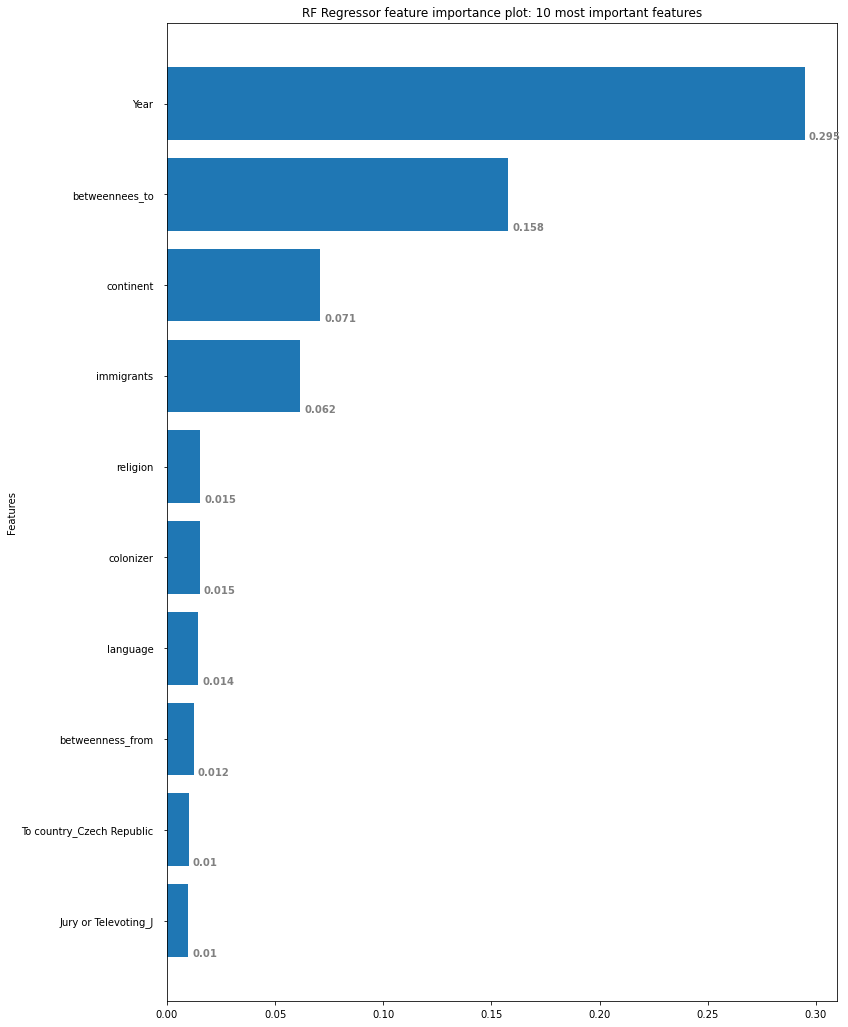

In [72]:
#Show 10 most important features
sortedidx = RF.feature_importances_.argsort()
N=10

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(dataf.columns[sortedidx[-N:]], RF.feature_importances_[sortedidx[-N:]])


ax.set_ylabel('Features')
ax.set_title('RF Regressor feature importance plot: 10 most important features')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y(),
             str(round((i.get_width()), 3)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.show()

In [73]:
Y_pred = RF.predict(X_test)

In [74]:
print('Mean Absolute Error:', mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, Y_pred)))

Mean Absolute Error: 2.5180484876686826
Mean Squared Error: 11.123567211826895
Root Mean Squared Error: 3.33520122508776


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

In [ ]:
rf_random.best_params_

In [ ]:
Pipe4 = Pipeline([
    ('regressor', RandomForestRegressor(n_estimators=3155, min_samples_split=10, min_samples_leaf=2, max_features='auto',
                                        max_depth=40, bootstrap=True, random_state=123))
])

In [ ]:
Pipe4.fit(X_train, Y_train)

In [ ]:
Pipe4.score(X_train, Y_train)

In [ ]:
pred_y = Pipe3.predict(X_test)

In [ ]:
print('Mean Absolute Error:', mean_absolute_error(Y_test, pred_Y))
print('Mean Squared Error:', mean_squared_error(Y_test, pred_Y))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, pred_Y)))

## Ridge Regression

In [ ]:
Pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', Ridge())
])

In [ ]:
Pipe3.fit(X_train, Y_train)

In [ ]:
Pipe3.score(X_train, Y_train)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

param = {
    'alpha':[.0001, 0.001,0.01, 0.01,1],
    'fit_intercept':[True,False],
    'normalize':[True,False],
'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }
#define model
model = Ridge()

# define search
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv, verbose=2)

# execute search
result = search.fit(X_train, Y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
Pipe3_optimized = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', Ridge(alpha= 1, fit_intercept= True, normalize= False, solver='svd'))
])

In [ ]:
Pipe3_optimized.fit(X_train, Y_train)

In [ ]:
Pipe3_optimized.score(X_train, Y_train)

## Gradient Boosting Regressor

In [ ]:
#Parameter grid for Gradient Boosting Regression
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000,1500],
                  'max_depth'    : [4,6,8,10]
                 }

In [ ]:
GBR = GradientBoostingRegressor()

In [ ]:
grid_gbr = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 3, n_jobs=-1)

In [ ]:
grid_gbr.fit(X_train, Y_train)

In [ ]:
grid_gbr.best_params_

In [ ]:
Pipe5 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, subsample=0.9, max_depth=6, random_state=123))
])

In [ ]:
Pipe5.fit(X_train, Y_train)

In [ ]:
Pipe5.score(X_train, Y_train)

# Classifying
## Random Forest Classifier

In [ ]:
rfc_settings = {'criterion': ['gini', 'entropy'],
               'min_samples_split': [2,5,10],
               'min_samples_leaf': [1,2,4],
               'max_features': ['sqrt', 'log2', 'auto']
              }
rfc = RandomForestClassifier(n_estimators=5000)

In [ ]:
# Takes very long to run!
search_rfc = GridSearchCV(rfc, param_grid=rfc_settings, cv=3, verbose=2, n_jobs=-1)
search_rfc.fit(X_train, Y_train)

In [ ]:
search_rfc.best_params_

In [ ]:
Pipe6 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=5000, criterion='gini', min_samples_split= 2, min_samples_leaf= 2, max_features='log2', random_state=123))
])

In [ ]:
Pipe6.fit(X_train, Y_train)

In [ ]:
Pipe6.score(X_train, Y_train)

In [ ]:
rfc_pred = Pipe6.predict(X_test)

In [ ]:
print("Accuracy for Random Forest on test data: ",accuracy_score(Y_test,rfc_pred))

# Binary classification
## With XgBoost

If the country received points (1-12) from the other country, then Voting=1, otherwise 0.

In [75]:
data_final.loc[data_final['Points'] == 0, 'Voting'] = 0
data_final.loc[data_final['Points'] != 0, 'Voting'] = 1

In [76]:
dataf = pd.concat([data_final, data_ohe], axis=1, join="outer")

In [77]:
dataf['Voting'] = dataf['Voting'].astype(int)

In [78]:
dataf['Voting'].value_counts()

0    15430
1    11432
Name: Voting, dtype: int64

In [79]:
dataf = dataf.drop(columns=['From country', 'To country', 'Jury or Televoting'])

In [80]:
x = dataf.drop(columns = ['Points', 'Voting'])
y = dataf['Voting']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state=123, stratify=Y, shuffle=True)

In [81]:
xg_clas = xgb.XGBClassifier(objective = 'binary:logistic')

In [82]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [83]:
grid_cv = GridSearchCV(xg_clas, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

In [84]:
grid_cv.fit(x_train, y_train)

C:\Users\Eva\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Eva\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:43:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, v

In [85]:
grid_cv.best_score_

0.6864523967180988

In [86]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [87]:
final_xgb = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=0.5, subsample=0.8, gamma=0.25, 
                              learning_rate=0.1, max_depth=7, reg_lambda=0, scale_pos_weight=1)

In [88]:
final_xgb.fit(x_train, y_train)

[18:45:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.25, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [89]:
y_pred_proba = final_xgb.predict_proba(x_test)[:, 1]

In [90]:
AUC = roc_auc_score(y_test, y_pred_proba)

In [91]:
y_pred = final_xgb.predict(x_test)

In [92]:
recall_score(y_test, y_pred)

0.4689481740651651

In [93]:
precision_score(y_test, y_pred)

0.6386241810601548

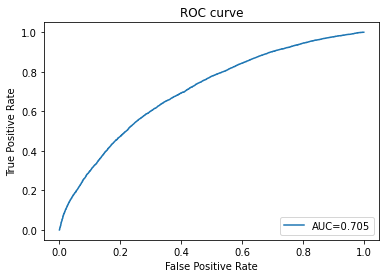

In [94]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(round(AUC, 3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

In [95]:
#Variable importance values
for col,score in zip(x_train.columns, final_xgb.feature_importances_):
    print(col,score)

Year 0.011636884
religion 0.0066004964
language 0.019850638
colonizer 0.00899345
immigrants 0.0068148933
continent 0.01271222
timezone 0.015188881
distance 0.008813682
betweenness_from 0.006313492
betweennees_to 0.010708968
From country_Belgium 0.008661802
From country_Finland 0.0101237465
From country_France 0.007902591
From country_Germany 0.0077346303
From country_Ireland 0.011350608
From country_Israel 0.009305126
From country_Italy 0.008049793
From country_Luxembourg 0.005607086
From country_Malta 0.0050564655
From country_Monaco 0.009950622
From country_Norway 0.005334889
From country_Portugal 0.008781805
From country_Spain 0.009307207
From country_Sweden 0.00650298
From country_Switzerland 0.010922525
From country_Turkey 0.012058759
From country_United Kingdom 0.0091840755
From country_Austria 0.0073666116
From country_Greece 0.008261036
From country_Denmark 0.011429341
From country_Morocco 0.0
From country_Cyprus 0.008800733
From country_Iceland 0.004287986
From country_Croatia

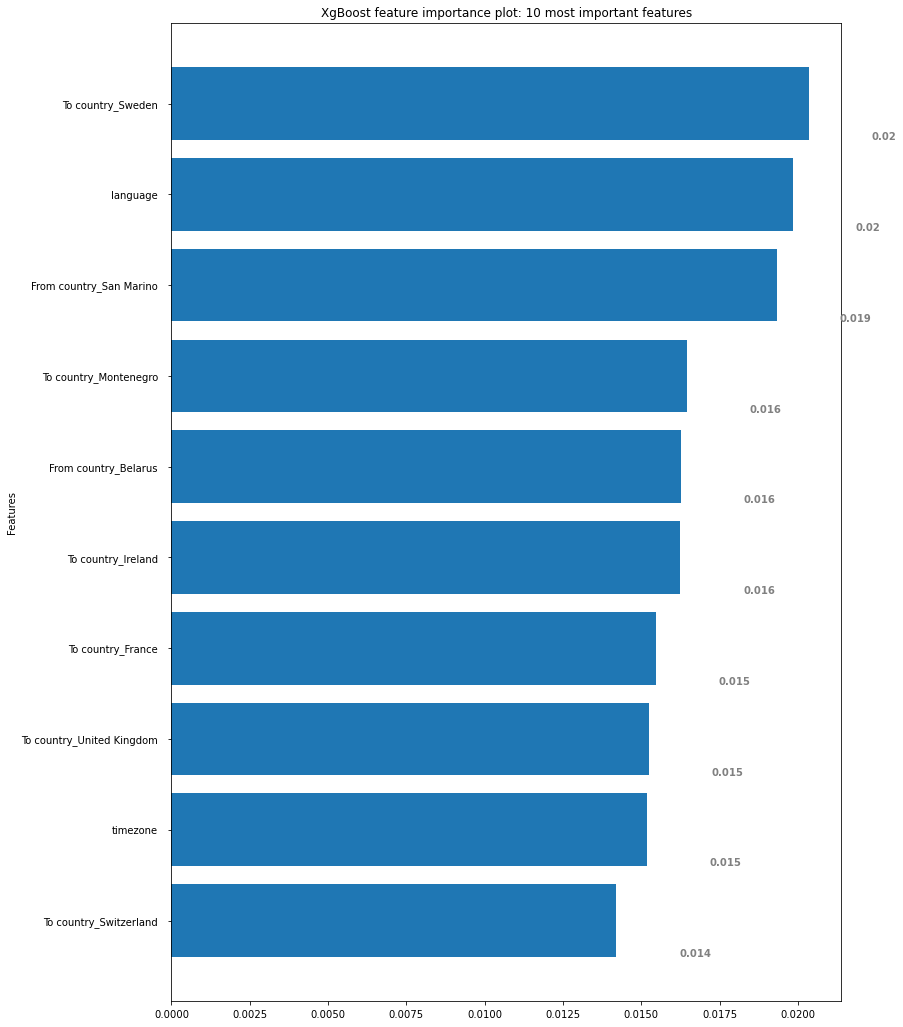

In [96]:
#Show 10 most important features
sorted_idx = final_xgb.feature_importances_.argsort()
N=10

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(dataf.columns[sorted_idx[-N:]], final_xgb.feature_importances_[sorted_idx[-N:]])


ax.set_ylabel('Features')
ax.set_title('XgBoost feature importance plot: 10 most important features')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y(),
             str(round((i.get_width()), 3)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.show()

## Prediction for 2023
### With XgBoost

In [153]:
X_pred = data_final.drop(columns=['Year'])

In [154]:
X_pred['Year'] = 2023

In [155]:
x_cat = X_pred[['From country', 'To country', 'Jury or Televoting']]
x_ohe = ohe.fit_transform(x_cat)

C:\Users\Eva\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [156]:
x_pred = pd.concat([X_pred, x_ohe], axis=1, join='outer')

In [157]:
x_pred = x_pred.drop(columns=['From country', 'To country', 'Jury or Televoting', 'Points', 'Voting'])

In [158]:
pred_2023 = final_xgb.predict(x_pred)

In [159]:
pred2023 = pd.DataFrame(pred_2023)

In [160]:
X_pred = X_pred.reset_index(drop=True)

In [161]:
pred = pd.concat([X_pred, pred2023], axis=1)

In [162]:
pred = pred.drop(columns=['religion', 'language', 'colonizer', 'immigrants', 'continent', 'timezone', 'distance', 'betweenness_from', 'betweenness_to', 'Points', 'Voting'])

In [163]:
pred.rename(columns={0:'Voted'}, inplace=True)

In [164]:
pred.head()

,From country,To country,Jury or Televoting,Year,Voted
0,Belgium,Finland,J,2023,1
1,Belgium,France,J,2023,1
2,Belgium,Germany,J,2023,1
3,Belgium,Ireland,J,2023,1
4,Belgium,Israel,J,2023,1


In [165]:
pred.drop_duplicates(subset=['From country', 'To country', 'Jury or Televoting'], inplace=True)

In [166]:
#Deleting countries that no longer exists or do no participate in Eurovision anymore
countries_delete = ['Yugoslavia', 'Monaco', 'Morocco', 'Serbia & Montenegro', 'Andorra', 'Luxembourg']
pred = pred[pred['From country'].isin(countries_delete) == False]
pred = pred[pred['To country'].isin(countries_delete) == False]

In [167]:
#Separate predictions for Jury and Televoting
Jury2023 = pred[pred['Jury or Televoting'] == 'J']
Tele2023 = pred[pred['Jury or Televoting'] == 'T']

In [171]:
Jury2023.shape

(1611, 5)

In [172]:
Tele2023.shape

(1434, 5)

In [ ]:
#To output the dataset (format can be changed)
#Jury2023.to_csv('.\data\Jury2023.csv', index=False, header=False)
#Tele2023.to_csv('.\data\Tele2023.csv', index=False, header=False)

### And random forest regressor

In [173]:
pred_rf = RF.predict(x_pred)

C:\Users\Eva\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [174]:
pred_rf = pd.DataFrame(pred_rf)

In [175]:
predrf = pd.concat([X_pred, pred_rf], axis=1)

In [177]:
predrf = predrf.drop(columns=['religion', 'language', 'colonizer', 'immigrants', 'continent', 'timezone', 'distance', 'betweenness_from', 'betweenness_to', 'Points', 'Voting'])

In [178]:
predrf.rename(columns={0:'Voted'}, inplace=True)

In [179]:
predrf.head()

,From country,To country,Jury or Televoting,Year,Voted
0,Belgium,Finland,J,2023,3.9354
1,Belgium,France,J,2023,4.0398
2,Belgium,Germany,J,2023,4.0038
3,Belgium,Ireland,J,2023,3.9710
4,Belgium,Israel,J,2023,2.9320


In [180]:
predrf.drop_duplicates(subset=['From country', 'To country', 'Jury or Televoting'], inplace=True)

In [181]:
#Deleting countries that no longer exists or do no participate in Eurovision anymore
countries_delete = ['Yugoslavia', 'Monaco', 'Morocco', 'Serbia & Montenegro', 'Andorra', 'Luxembourg']
predrf = predrf[predrf['From country'].isin(countries_delete) == False]
predrf = predrf[predrf['To country'].isin(countries_delete) == False]

In [182]:
Jury2023RF = predrf[predrf['Jury or Televoting'] == 'J']
Tele2023RF = predrf[predrf['Jury or Televoting'] == 'T']

In [183]:
Jury2023RF.shape

(1611, 5)

In [184]:
Tele2023RF.shape

(1434, 5)

In [ ]:
#To output the dataset
#Jury2023RF.to_csv('.\data\Jury2023RF.csv', index=False, header=False)
#Tele2023RF.to_csv('.\data\Tele2023RF.csv', index=False, header=False)